In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

sns.set(color_codes=True)

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving client_data.csv to client_data.csv
Saving price_data.csv to price_data.csv


In [3]:
client_df = pd.read_csv('client_data.csv')
price_df = pd.read_csv('price_data.csv')

In [4]:

#add year feature to dataframe
client_df['contract_start_year'] = client_df['date_activ'].dt.year
client_df['cortract_end_year'] = client_df['date_end'].dt.year

In [5]:
from sklearn.preprocessing import LabelEncoder

channel_encoder = LabelEncoder()

client_df['channel_sales'] = channel_encoder.fit_transform(client_df['channel_sales'])

origin_encoder = LabelEncoder()

client_df['origin_up'] = origin_encoder.fit_transform(client_df['origin_up'])

In [6]:
#fix too complicated..
def diff_price_by_attribute(df, attr):
    price_dec = df.sort_values(by=['price_date']).groupby(['id'])[attr].last().reset_index()
    price_jan = df.sort_values(by=['price_date']).groupby(['id'])[attr].first().reset_index()
    price_dec[f'diff_dec_jan_{attr}'] = price_dec[attr] - price_jan[attr]
    
    return price_dec
    


In [7]:
train_data = client_df.copy()


price_df.info()
attrs = ['price_off_peak_var', 'price_off_peak_fix']

for attr in attrs:
  difference_data = diff_price_by_attribute(df=price_df, attr=attr)
  train_data = train_data.merge(difference_data[['id', f'diff_dec_jan_{attr}']],
                                on='id', how='left')

print(train_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB
                                 id  channel_sales  cons_12m  cons_gas_12m  \
0  24011ae4ebbe3035111d65fa7c15bc57              4         0         54946   
1  d29c2c54acc38ff3c0614d0a653813dd              0      4660             0   
2  764c75f661154dac3a6c254cd082ea7d              4       544             0   
3  bba03439a292a1e166f802

In [8]:

#data preprocessing

#drop useless columns
drop_columns = ['date_activ','date_end','date_modif_prod','date_renewal']
train_data = train_data.drop(columns=drop_columns)

#make gas to categorical
gas_encoder = LabelEncoder()
train_data['has_gas'] = gas_encoder.fit_transform(train_data['has_gas'])










 Create training data and training label.

Note: for tree-based models

    there is no need to perform data scaling, unlike other machine learning models.
    do not apply one-hot encoding to processing categorical variables, just use label-encoding to convert categorical variables to numeric variables.

In [9]:
X = train_data.drop(columns=['id', 'churn'])
y = train_data['churn']

X.shape, y.shape

((14606, 24), (14606,))

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np


pred_train_labels = np.zeros(shape=(X.shape[0], 2))

feature_importance_df = pd.DataFrame(data={'feature_name':X.columns, 'feature_importance':[0]*len(X.columns)})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)






RandomForestClassifier(random_state=42)

In [11]:
all_predictors = []
  
preds = rf.predict(X_test)
preds = pd.Series(preds, index=y_test.index)

predictions = pd.concat([y_test, preds], axis=1)
predictions.columns = ['actual', 'prediction']

print(predictions)







       actual  prediction
4947        0           0
5868        0           0
6805        0           0
1323        0           0
11759       0           0
...       ...         ...
8846        0           0
4075        0           0
11619       0           0
2992        0           0
1369        0           0

[2922 rows x 2 columns]


In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(predictions['actual'], predictions['prediction'])

0.9000684462696783

Performance of algorithm is not very good. Only by estimating that all cases are not churn, we can have better performance. 

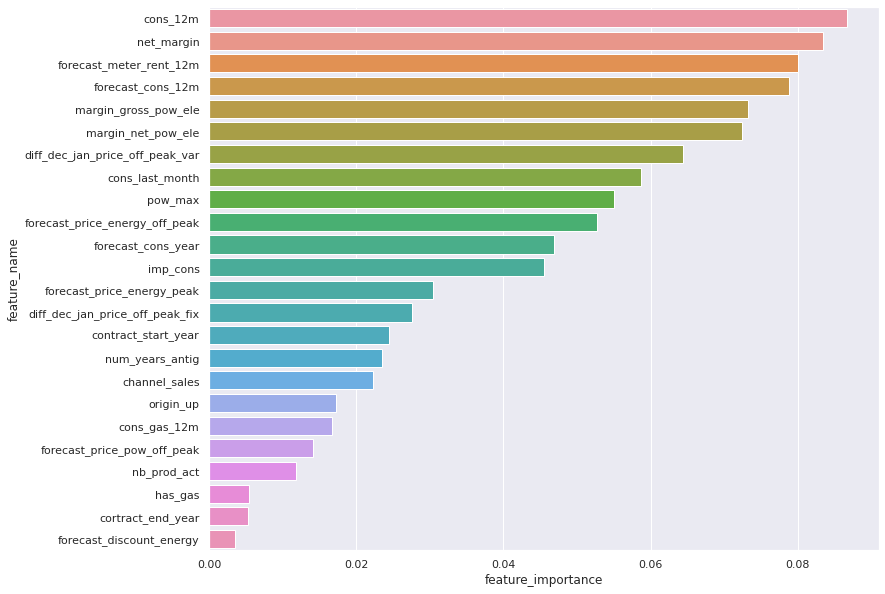

In [14]:
##lets calc and evaluate the feature importances

feature_importance_df['feature_importance'] = feature_importance_df['feature_importance'] + (rf.feature_importances_)

fig = plt.figure(figsize=(12,10))

ax = sns.barplot(data=feature_importance_df.sort_values(by=['feature_importance'],
                                                        ascending=False), y='feature_name', 
                 x='feature_importance')



In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       0.84      0.05      0.10       305

    accuracy                           0.90      2922
   macro avg       0.87      0.53      0.52      2922
weighted avg       0.89      0.90      0.86      2922



Out of positive churn predicted 84% were right, but the model found only 5% of actual positive cases. F1 value is very far away from 1, so it tells that the model is doing poor job. 

**Random forest pros and cons**

Pros:

- Can be used for classification, and regression
- Works well with categorical and numerical data
- Can handle linear and non-linear realationships

Cons: 
- Random Forests are not easily interpretable. They provide feature importance but it does not provide complete visibility into the coefficients as linear regression.
- Black box algrithm, so you have very little control on model 